# 1. Data Exploration

In [1]:
#Importing the basic librarires

import os
import math
import scipy
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
import geopy.distance
from tqdm import tqdm
from IPython.display import display

from statsmodels.formula import api
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10,6]

import warnings 
warnings.filterwarnings('ignore')

In [2]:
#Importing the dataset

df = pd.read_csv("C:\\Users\\Bhaskar Adhikary\\Desktop\\Tools Practices\\UBER PROJECT\\uber.csv")

df.drop(['Unnamed: 0','key'], axis=1, inplace=True)
display(df.head())

target = 'fare_amount'
features = [i for i in df.columns if i not in [target]]

print('\n\033[1mInference:\033[0m The Datset consists of {} features & {} samples.'.format(df.shape[1], df.shape[0]))

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5



Inference: The Datset consists of 7 features & 200000 samples.


In [3]:
#Check for empty elements

nvc = pd.DataFrame(df.isnull().sum().sort_values(), columns=['Total Null Values'])
nvc['Percentage'] = round(nvc['Total Null Values']/df.shape[0],3)*100
print(nvc)
df.dropna(inplace=True)

                   Total Null Values  Percentage
fare_amount                        0         0.0
pickup_datetime                    0         0.0
pickup_longitude                   0         0.0
pickup_latitude                    0         0.0
passenger_count                    0         0.0
dropoff_longitude                  1         0.0
dropoff_latitude                   1         0.0


In [4]:
# Reframing the columns

df = df[(df.pickup_latitude<90) & (df.dropoff_latitude<90) &
        (df.pickup_latitude>-90) & (df.dropoff_latitude>-90) &
        (df.pickup_longitude<180) & (df.dropoff_longitude<180) &
        (df.pickup_longitude>-180) & (df.dropoff_longitude>-180)]

df.pickup_datetime=pd.to_datetime(df.pickup_datetime)

df['year'] = df.pickup_datetime.dt.year
df['month'] = df.pickup_datetime.dt.month
df['weekday'] = df.pickup_datetime.dt.weekday
df['hour'] = df.pickup_datetime.dt.hour

df['Monthly_Quarter'] = df.month.map({1:'Q1',2:'Q1',3:'Q1',4:'Q2',5:'Q2',6:'Q2',7:'Q3',
                                      8:'Q3',9:'Q3',10:'Q4',11:'Q4',12:'Q4'})
df['Hourly_Segments'] = df.hour.map({0:'H1',1:'H1',2:'H1',3:'H1',4:'H2',5:'H2',6:'H2',7:'H2',8:'H3',
                                     9:'H3',10:'H3',11:'H3',12:'H4',13:'H4',14:'H4',15:'H4',16:'H5',
                                     17:'H5',18:'H5',19:'H5',20:'H6',21:'H6',22:'H6',23:'H6'})

df['Distance']=[round(geopy.distance.distance((df.pickup_latitude[i], df.pickup_longitude[i]),(df.dropoff_latitude[i], df.dropoff_longitude[i])).m,2) for i in df.index]

df.drop(['pickup_datetime','month', 'hour',], axis=1, inplace=True)

original_df = df.copy(deep=True)

df.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,weekday,Monthly_Quarter,Hourly_Segments,Distance
0,7.5,-73.999817,40.738354,-73.999512,40.723217,1,2015,3,Q2,H5,1681.11
1,7.7,-73.994355,40.728225,-73.994710,40.750325,1,2009,4,Q3,H6,2454.36
2,12.9,-74.005043,40.740770,-73.962565,40.772647,1,2009,0,Q3,H6,5039.60
3,5.3,-73.976124,40.790844,-73.965316,40.803349,3,2009,4,Q2,H3,1661.44
4,16.0,-73.925023,40.744085,-73.973082,40.761247,5,2014,3,Q3,H5,4483.73


In [5]:
#Checking the dtypes of all the columns

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199987 entries, 0 to 199999
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   fare_amount        199987 non-null  float64
 1   pickup_longitude   199987 non-null  float64
 2   pickup_latitude    199987 non-null  float64
 3   dropoff_longitude  199987 non-null  float64
 4   dropoff_latitude   199987 non-null  float64
 5   passenger_count    199987 non-null  int64  
 6   year               199987 non-null  int64  
 7   weekday            199987 non-null  int64  
 8   Monthly_Quarter    199987 non-null  object 
 9   Hourly_Segments    199987 non-null  object 
 10  Distance           199987 non-null  float64
dtypes: float64(6), int64(3), object(2)
memory usage: 22.3+ MB


In [6]:
#Checking number of unique rows in each feature

df.nunique().sort_values()

Monthly_Quarter           4
Hourly_Segments           6
year                      7
weekday                   7
passenger_count           8
fare_amount            1244
pickup_longitude      71055
dropoff_longitude     76890
pickup_latitude       83831
dropoff_latitude      90582
Distance             164542
dtype: int64

In [7]:
#Checking number of unique rows in each feature

nu = df.drop([target], axis=1).nunique().sort_values()
nf = []; cf = []; nnf = 0; ncf = 0; #numerical & categorical features

for i in range(df.drop([target], axis=1).shape[1]):
    if nu.values[i]<=24:cf.append(nu.index[i])
    else: nf.append(nu.index[i])

print('\n\033[1mInference:\033[0m The Datset has {} numerical & {} categorical features.'.format(len(nf),len(cf)))


Inference: The Datset has 5 numerical & 5 categorical features.


In [8]:
#Checking the stats of all the columns

display(df.describe())

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,weekday,Distance
count,199987.000000,199987.000000,199987.000000,199987.000000,199987.000000,199987.000000,199987.000000,199987.000000,1.999870e+05
mean,11.359849,-72.501786,39.917937,-72.511608,39.922031,1.684544,2011.742463,3.048383,2.056346e+04
std,9.901868,10.449955,6.130412,10.412192,6.117669,1.385999,1.856438,1.946960,3.796638e+05
min,-52.000000,-93.824668,-74.015515,-75.458979,-74.015750,0.000000,2009.000000,0.000000,0.000000e+00
25%,6.000000,-73.992064,40.734793,-73.991407,40.733823,1.000000,2010.000000,1.000000,1.215530e+03
50%,8.500000,-73.981822,40.752592,-73.980092,40.753042,1.000000,2012.000000,3.000000,2.121280e+03
75%,12.500000,-73.967154,40.767157,-73.963658,40.768000,2.000000,2013.000000,5.000000,3.874255e+03
max,499.000000,40.808425,48.018760,40.831932,45.031598,208.000000,2015.000000,6.000000,8.783594e+06


# 2. Exploratory Data Analysis (EDA)

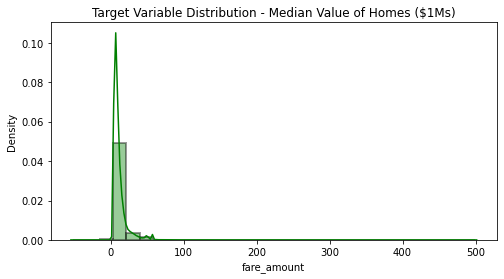

In [9]:
#Let us first analyze the distribution of the target variable

plt.figure(figsize=[8,4])
sns.distplot(df[target], color='g',hist_kws=dict(edgecolor="black", linewidth=2), bins=30)
plt.title('Target Variable Distribution - Median Value of Homes ($1Ms)')
plt.show()

Inference:The Target Variable seems to be be highly skewed, with most datapoints lieing near 0

                               Visualising Categorical Features:                                


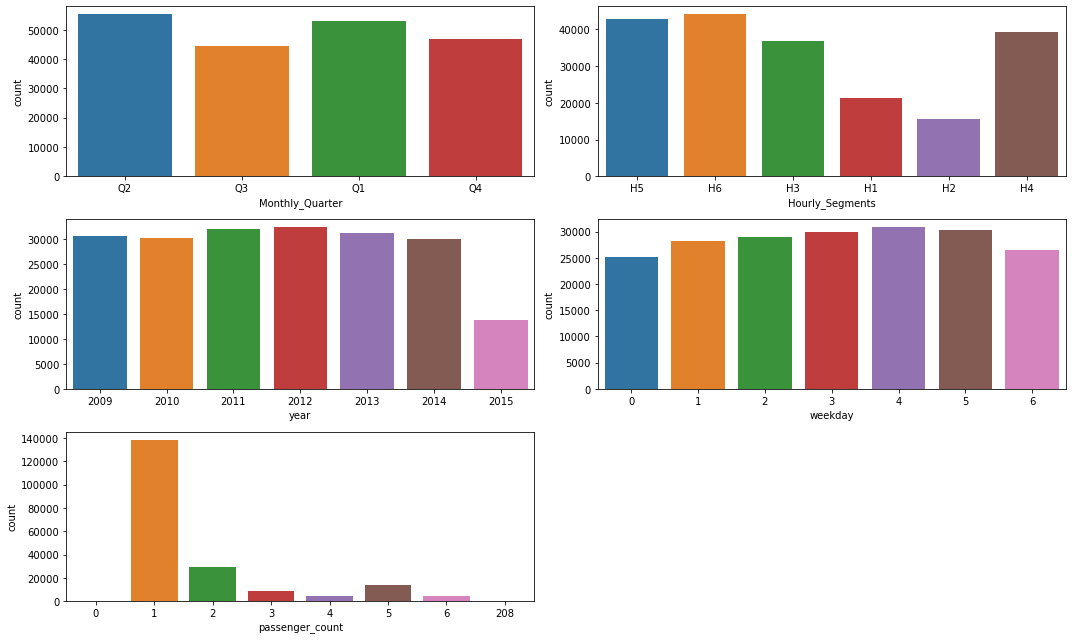

In [10]:
#Visualising the categorical features 

print('\033[1mVisualising Categorical Features:'.center(100))

n=2
plt.figure(figsize=[15,3*math.ceil(len(cf)/n)])

# for i in range(len(cf)):
#     if df[cf[i]].nunique()<=4:
#         plt.subplot(math.ceil(len(cf)/n),n,i+1)
#         sns.countplot(df[cf[i]])
#     else:
#         plt.subplot(math.ceil(len(cf)/2),2,i)
#         sns.countplot(df[cf[i]])

for i in range(len(cf)):
    if df[cf[i]].nunique()<=12:
        plt.subplot(math.ceil(len(cf)/n),n,i+1)
        sns.countplot(df[cf[i]])
    else:
        plt.subplot(3,1,i-3)
        sns.countplot(df[cf[i]])
        #plt.subplot(4,2,8)
        #sns.countplot(df[cf[i]])
        
plt.tight_layout()
plt.show()

Inference: The categorical features distribution can be seen in the above plots.

                                 Numeric Features Distribution                                  


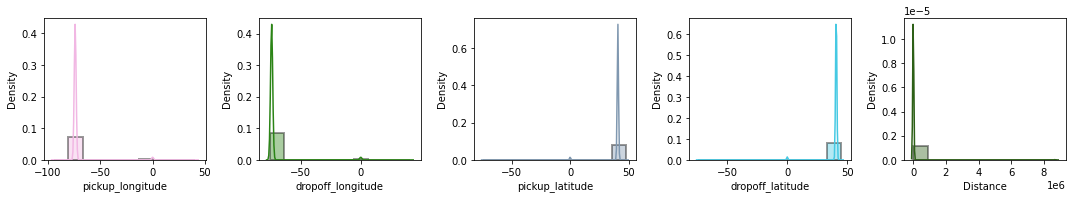

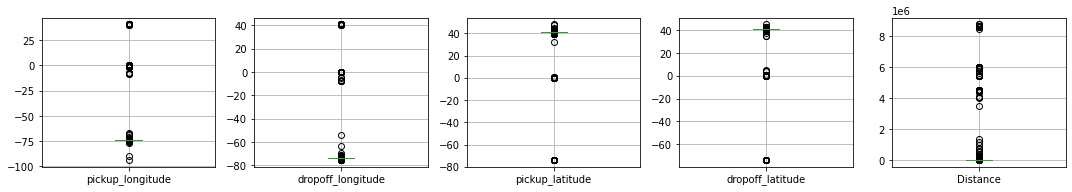

In [11]:
#Visualising the numeric features 

print('\033[1mNumeric Features Distribution'.center(100))

n=5

plt.figure(figsize=[15,5*math.ceil(len(nf)/n)])
for i in range(len(nf)):
    plt.subplot(math.ceil(len(nf)/3),n,i+1)
    sns.distplot(df[nf[i]],hist_kws=dict(edgecolor="black", linewidth=2), bins=10, color=list(np.random.randint([255,255,255])/255))
plt.tight_layout()
plt.show()

plt.figure(figsize=[15,5*math.ceil(len(nf)/n)])
for i in range(len(nf)):
    plt.subplot(math.ceil(len(nf)/3),n,i+1)
    df.boxplot(nf[i])
plt.tight_layout()
plt.show()

Inference: There seem to be some outliers. let us fix these in the upcoming section...

### 3. Data Preprocessing

In [12]:
#Removal of any Duplicate rows (if any)

counter = 0
rs,cs = original_df.shape

df.drop_duplicates(inplace=True)
df.drop(['pickup_latitude','pickup_longitude',
         'dropoff_latitude','dropoff_longitude'],axis=1)

if df.shape==(rs,cs):
    print('\n\033[1mInference:\033[0m The dataset doesn\'t have any duplicates')
else:
    print(f'\n\033[1mInference:\033[0m Number of duplicates dropped/fixed ---> {rs-df.shape[0]}')


Inference: Number of duplicates dropped/fixed ---> 109


In [13]:
#Converting categorical Columns to Numeric

df1 = df.copy()
df3 = df1.copy()

ecc = nvc[nvc['Percentage']!=0].index.values
fcc = [i for i in cf if i not in ecc]
#One-Hot Binay Encoding
oh=True
dm=True
for i in fcc:
    #print(i)
    if df3[i].nunique()==2:
        if oh==True: print("\033[1mOne-Hot Encoding on features:\033[0m")
        print(i);oh=False
        df3[i]=pd.get_dummies(df3[i], drop_first=True, prefix=str(i))
    if (df3[i].nunique()>2 and df3[i].nunique()<17):
        if dm==True: print("\n\033[1mDummy Encoding on features:\033[0m")
        print(i);dm=False
        df3 = pd.concat([df3.drop([i], axis=1), pd.DataFrame(pd.get_dummies(df3[i], drop_first=True, prefix=str(i)))],axis=1)
        
df3.shape


Dummy Encoding on features:
Monthly_Quarter
Hourly_Segments
year
weekday
passenger_count


(199878, 33)

In [14]:
#Removal of outlier:

df1 = df3.copy()

#features1 = [i for i in features if i not in ['CHAS','RAD']]
features1 = nf

for i in features1:
    Q1 = df1[i].quantile(0.25)
    Q3 = df1[i].quantile(0.75)
    IQR = Q3 - Q1
    df1 = df1[df1[i] <= (Q3+(1.5*IQR))]
    df1 = df1[df1[i] >= (Q1-(1.5*IQR))]
    df1 = df1.reset_index(drop=True)
display(df1.head())
print('\n\033[1mInference:\033[0m\nBefore removal of outliers, The dataset had {} samples.'.format(df3.shape[0]))
print('After removal of outliers, The dataset now has {} samples.'.format(df1.shape[0]))

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,Distance,Monthly_Quarter_Q2,Monthly_Quarter_Q3,Monthly_Quarter_Q4,Hourly_Segments_H2,...,weekday_4,weekday_5,weekday_6,passenger_count_1,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,passenger_count_208
0,7.5,-73.999817,40.738354,-73.999512,40.723217,1681.11,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,7.7,-73.994355,40.728225,-73.994710,40.750325,2454.36,0,1,0,0,...,1,0,0,1,0,0,0,0,0,0
2,12.9,-74.005043,40.740770,-73.962565,40.772647,5039.60,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
3,5.3,-73.976124,40.790844,-73.965316,40.803349,1661.44,1,0,0,0,...,1,0,0,0,0,1,0,0,0,0
4,4.9,-73.969019,40.755910,-73.969019,40.755910,0.00,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0



Inference:
Before removal of outliers, The dataset had 199878 samples.
After removal of outliers, The dataset now has 163203 samples.


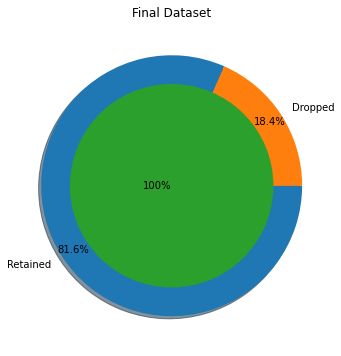


Inference: After the cleanup process, 36784 samples were dropped, while retaining 18.39% of the data.


In [15]:
#Final Dataset size after performing Preprocessing

df = df1.copy()
df.columns=[i.replace('-','_') for i in df.columns]

plt.title('Final Dataset')
plt.pie([df.shape[0], original_df.shape[0]-df.shape[0]], radius = 1, labels=['Retained','Dropped'], counterclock=False, 
        autopct='%1.1f%%', pctdistance=0.9, explode=[0,0], shadow=True)
plt.pie([df.shape[0]], labels=['100%'], labeldistance=-0, radius=0.78)
plt.show()

print(f'\n\033[1mInference:\033[0m After the cleanup process, {original_df.shape[0]-df.shape[0]} samples were dropped, \
while retaining {round(100 - (df.shape[0]*100/(original_df.shape[0])),2)}% of the data.')

### 4. Data Manipulation

In [16]:
#Splitting the data intro training & testing sets

m=[]
for i in df.columns.values:
    m.append(i.replace(' ','_'))
    
df.columns = m
X = df.drop([target],axis=1)
Y = df[target]
Train_X, Test_X, Train_Y, Test_Y = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=100)
Train_X.reset_index(drop=True,inplace=True)

print('Original set  ---> ',X.shape,Y.shape,'\nTraining set  ---> ',Train_X.shape,Train_Y.shape,'\nTesting set   ---> ', Test_X.shape,'', Test_Y.shape)

Original set  --->  (163203, 32) (163203,) 
Training set  --->  (130562, 32) (130562,) 
Testing set   --->  (32641, 32)  (32641,)


In [17]:
#Feature Scaling (Standardization)

std = StandardScaler()

print('\033[1mStandardardization on Training set'.center(100))
Train_X_std = std.fit_transform(Train_X)
Train_X_std = pd.DataFrame(Train_X_std, columns=X.columns)
display(Train_X_std.describe())

print('\n','\033[1mStandardardization on Testing set'.center(100))
Test_X_std = std.transform(Test_X)
Test_X_std = pd.DataFrame(Test_X_std, columns=X.columns)
display(Test_X_std.describe())

                               Standardardization on Training set                               


,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,Distance,Monthly_Quarter_Q2,Monthly_Quarter_Q3,Monthly_Quarter_Q4,Hourly_Segments_H2,Hourly_Segments_H3,...,weekday_4,weekday_5,weekday_6,passenger_count_1,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,passenger_count_208
count,1.305620e+05,1.305620e+05,1.305620e+05,1.305620e+05,1.305620e+05,1.305620e+05,1.305620e+05,1.305620e+05,1.305620e+05,1.305620e+05,...,1.305620e+05,1.305620e+05,1.305620e+05,1.305620e+05,1.305620e+05,1.305620e+05,1.305620e+05,1.305620e+05,1.305620e+05,1.305620e+05
mean,-6.304892e-13,-2.335703e-15,-1.255051e-13,1.803562e-14,-1.397349e-16,-5.364534e-15,1.615100e-15,-1.027500e-15,4.044123e-15,-2.618668e-15,...,-1.316621e-15,2.291492e-16,3.253467e-16,6.353702e-16,1.735940e-15,1.159121e-15,3.149257e-15,-2.750499e-15,-4.009598e-15,-1.562710e-15
std,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,...,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00
min,-2.961437e+00,-2.897556e+00,-2.919757e+00,-2.867446e+00,-1.622863e+00,-6.155085e-01,-5.316226e-01,-5.558634e-01,-2.767434e-01,-4.873355e-01,...,-4.292020e-01,-4.216941e-01,-3.801548e-01,-1.505327e+00,-4.122782e-01,-2.171248e-01,-1.483366e-01,-2.738455e-01,-1.464379e-01,-2.767536e-03
25%,-6.783829e-01,-6.847366e-01,-6.710313e-01,-6.636110e-01,-7.629052e-01,-6.155085e-01,-5.316226e-01,-5.558634e-01,-2.767434e-01,-4.873355e-01,...,-4.292020e-01,-4.216941e-01,-3.801548e-01,-1.505327e+00,-4.122782e-01,-2.171248e-01,-1.483366e-01,-2.738455e-01,-1.464379e-01,-2.767536e-03
50%,-6.341797e-02,3.271920e-02,-6.532058e-02,4.834418e-02,-2.347775e-01,-6.155085e-01,-5.316226e-01,-5.558634e-01,-2.767434e-01,-4.873355e-01,...,-4.292020e-01,-4.216941e-01,-3.801548e-01,6.643075e-01,-4.122782e-01,-2.171248e-01,-1.483366e-01,-2.738455e-01,-1.464379e-01,-2.767536e-03
75%,6.429738e-01,6.539807e-01,6.174684e-01,6.350862e-01,5.652279e-01,1.624673e+00,-5.316226e-01,-5.558634e-01,-2.767434e-01,-4.873355e-01,...,-4.292020e-01,-4.216941e-01,-3.801548e-01,6.643075e-01,-4.122782e-01,-2.171248e-01,-1.483366e-01,-2.738455e-01,-1.464379e-01,-2.767536e-03
max,3.255964e+00,2.807711e+00,3.137233e+00,2.805374e+00,2.933357e+00,1.624673e+00,1.881034e+00,1.799003e+00,3.613456e+00,2.051975e+00,...,2.329905e+00,2.371387e+00,2.630507e+00,6.643075e-01,2.425547e+00,4.605646e+00,6.741425e+00,3.651694e+00,6.828835e+00,3.613323e+02



                                Standardardization on Testing set                                


,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,Distance,Monthly_Quarter_Q2,Monthly_Quarter_Q3,Monthly_Quarter_Q4,Hourly_Segments_H2,Hourly_Segments_H3,...,weekday_4,weekday_5,weekday_6,passenger_count_1,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,passenger_count_208
count,32641.000000,32641.000000,32641.000000,32641.000000,32641.000000,32641.000000,32641.000000,32641.000000,32641.000000,32641.000000,...,32641.000000,32641.000000,32641.000000,32641.000000,32641.000000,32641.000000,32641.000000,32641.000000,32641.000000,3.264100e+04
mean,0.009496,0.003957,0.002645,0.010718,0.003829,-0.004419,0.008474,-0.004463,0.001664,0.002463,...,-0.001824,0.000336,-0.000882,-0.005507,0.003732,-0.006578,0.000262,0.001559,0.013835,-2.767536e-03
std,1.002215,1.000929,0.993715,1.001776,1.001768,0.997773,1.005681,0.997227,1.002787,1.001937,...,0.998279,1.000343,0.999022,1.002313,1.003758,0.985453,1.000877,1.002644,1.045127,1.405581e-15
min,-2.708732,-2.887521,-2.876670,-2.857408,-1.622863,-0.615509,-0.531623,-0.555863,-0.276743,-0.487335,...,-0.429202,-0.421694,-0.380155,-1.505327,-0.412278,-0.217125,-0.148337,-0.273845,-0.146438,-2.767536e-03
25%,-0.674309,-0.688962,-0.664415,-0.652657,-0.762707,-0.615509,-0.531623,-0.555863,-0.276743,-0.487335,...,-0.429202,-0.421694,-0.380155,-1.505327,-0.412278,-0.217125,-0.148337,-0.273845,-0.146438,-2.767536e-03
50%,-0.048188,0.048564,-0.060663,0.060627,-0.230528,-0.615509,-0.531623,-0.555863,-0.276743,-0.487335,...,-0.429202,-0.421694,-0.380155,0.664307,-0.412278,-0.217125,-0.148337,-0.273845,-0.146438,-2.767536e-03
75%,0.653268,0.661489,0.621690,0.657956,0.574644,1.624673,-0.531623,-0.555863,-0.276743,-0.487335,...,-0.429202,-0.421694,-0.380155,0.664307,-0.412278,-0.217125,-0.148337,-0.273845,-0.146438,-2.767536e-03
max,3.252830,2.800652,3.132185,2.804325,2.932838,1.624673,1.881034,1.799003,3.613456,2.051975,...,2.329905,2.371387,2.630507,0.664307,2.425547,4.605646,6.741425,3.651694,6.828835,-2.767536e-03


### 5. Feature Selection/Extraction

                                       Correlation Matrix                                       


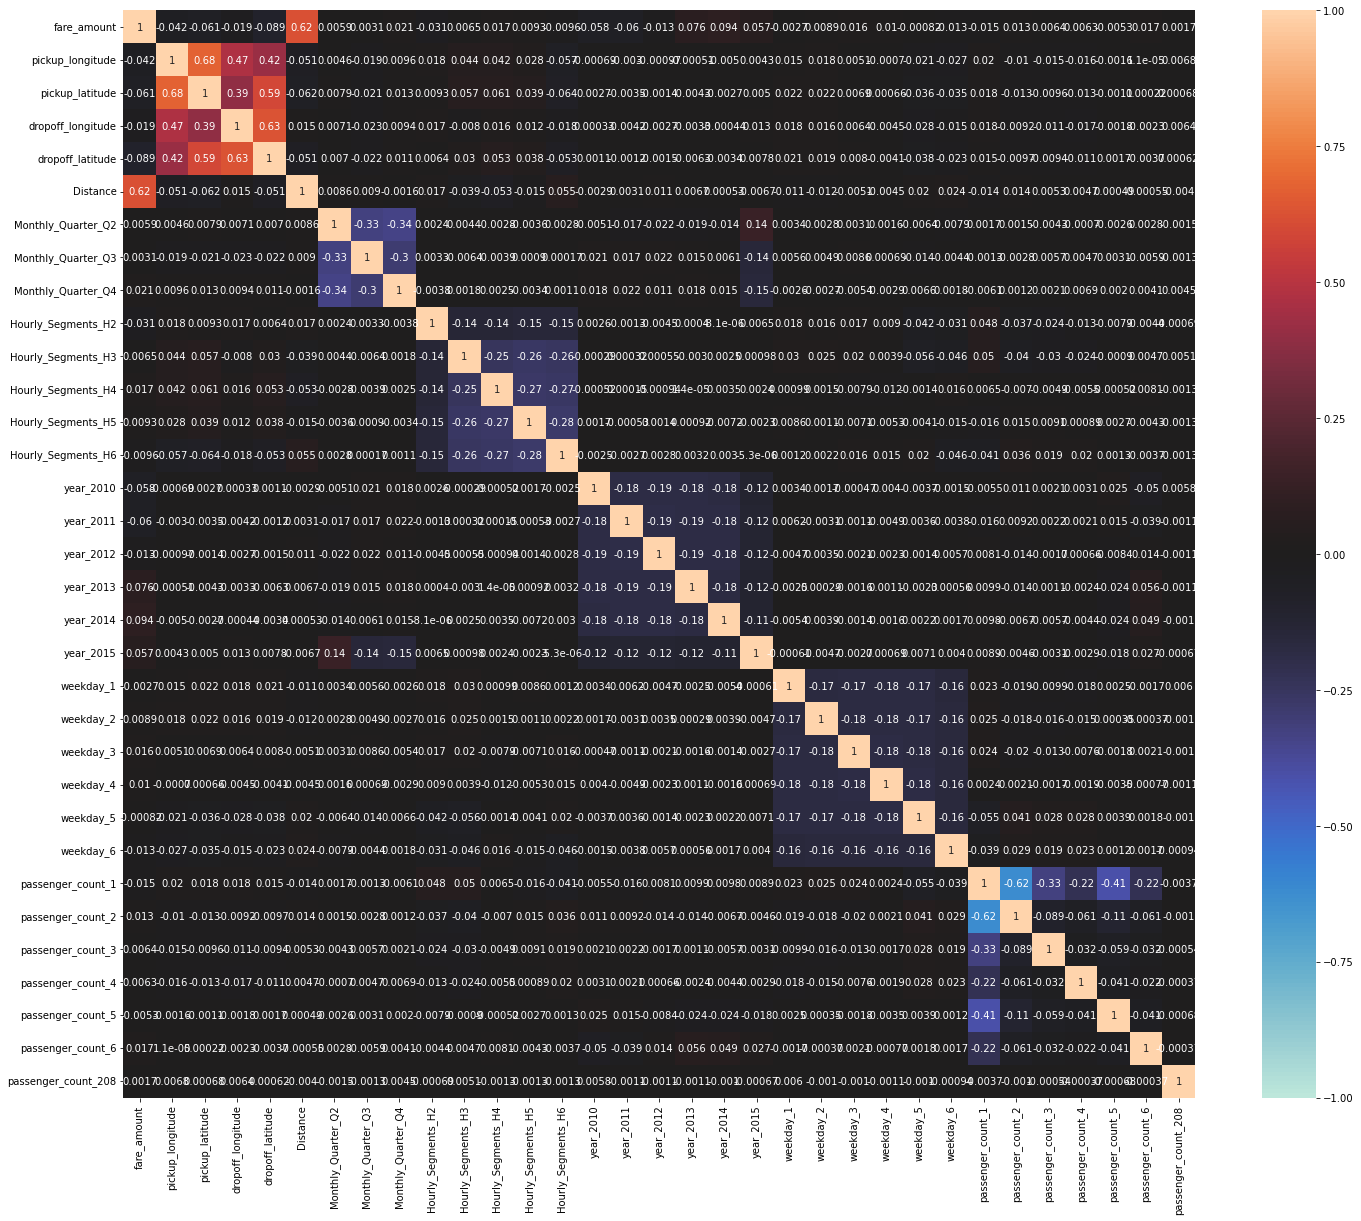

In [18]:
#Checking the correlation

print('\033[1mCorrelation Matrix'.center(100))
plt.figure(figsize=[24,20])
sns.heatmap(df.corr(), annot=True, vmin=-1, vmax=1, center=0) #cmap='BuGn'
plt.show()

In [25]:
#Testing a Linear Regression model with statsmodels

Train_xy = pd.concat([Train_X,Train_Y.reset_index(drop=True)],axis=1)
a = Train_xy.columns.values

API = api.ols(formula='{} ~ {}'.format(target,' + '.join(i for i in Train_X.columns)), data=Train_xy).fit()
API.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            fare_amount   R-squared:                       0.457
Model:                            OLS   Adj. R-squared:                  0.457
Method:                 Least Squares   F-statistic:                     3436.
Date:                Sun, 14 Jul 2024   Prob (F-statistic):               0.00
Time:                        20:36:13   Log-Likelihood:            -3.3661e+05
No. Observations:              130562   AIC:                         6.733e+05
Df Residuals:                  130529   BIC:                         6.736e+05
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            1036.8864     85.753     12.092      0.000     868.812    1204.961
pickup_longitude        0.7547      0.802      0.941      0.347      -0.817       2.327
pickup_latitude         1.1043      0.663      1.665      0.096      -0.195       2.404
dropoff_longitude       4.4888      0.729      6.153      0.000       3.059       5.919
dropoff_latitude      -16.9776      0.604    -28.113      0.000     -18.161     -15.794
Distance                0.0021    6.6e-06    314.210      0.000       0.002       0.002
Monthly_Quarter_Q2      0.1479      0.024      6.174      0.000       0.101       0.195
Monthly_Quarter_Q3      0.3185      0.026     12.348      0.000       0.268       0.369
Monthly_Quarter_Q4      0.5197      0.025     20.525      0.000       0.470       0.569
Hourly_Segments_H2     -0.2480      0.045     -5.563      0.000      -0.335      -0.161
Hourly_Segments_H3      0.8033      0.036     22.239      0.000       0.733       0.874
Hourly_Segments_H4      0.9938      0.035     28.006      0.000       0.924       1.063
Hourly_Segments_H5      0.7011      0.035     20.017      0.000       0.632       0.770
Hourly_Segments_H6      0.0871      0.035      2.494      0.013       0.019       0.156
year_2010               0.1195      0.032      3.756      0.000       0.057       0.182
year_2011               0.0771      0.032      2.445      0.015       0.015       0.139
year_2012               0.5323      0.031     16.912      0.000       0.471       0.594
year_2013               1.4822      0.032     46.623      0.000       1.420       1.544
year_2014               1.7470      0.032     54.333      0.000       1.684       1.810
year_2015               1.9042      0.041     45.907      0.000       1.823       1.985
weekday_1               0.2489      0.034      7.300      0.000       0.182       0.316
weekday_2               0.3675      0.034     10.824      0.000       0.301       0.434
weekday_3               0.4200      0.034     12.465      0.000       0.354       0.486
weekday_4               0.3504      0.034     10.453      0.000       0.285       0.416
weekday_5               0.0497      0.034      1.464      0.143      -0.017       0.116
weekday_6              -0.1686      0.036     -4.732      0.000      -0.238      -0.099
passenger_count_1       0.2151      0.148      1.451      0.147      -0.075       0.506
passenger_count_2       0.3693      0.150      2.467      0.014       0.076       0.663
passenger_count_3       0.3946      0.154      2.569      0.010       0.094       0.696
passenger_count_4       0.4779      0.160      2.993      0.003       0.165       0.791
passenger_count_5       0.3229      0.152      2.130      0.033       0.026       0.620
passenger_count_6       0.2356      0.160      1.470      0.141      -0.078       0.550
pas

5a. Manual Method - VIF

100%|██████████| 31/31 [01:44<00:00,  3.38s/it]

Dropped Features -->  ['passenger_count_1', 'Hourly_Segments_H5', 'pickup_latitude', 'weekday_4', 'dropoff_longitude', 'year_2012', 'Monthly_Quarter_Q4', 'Hourly_Segments_H6', 'weekday_5', 'year_2011', 'pickup_longitude', 'weekday_1', 'Monthly_Quarter_Q2', 'year_2013', 'Hourly_Segments_H3']


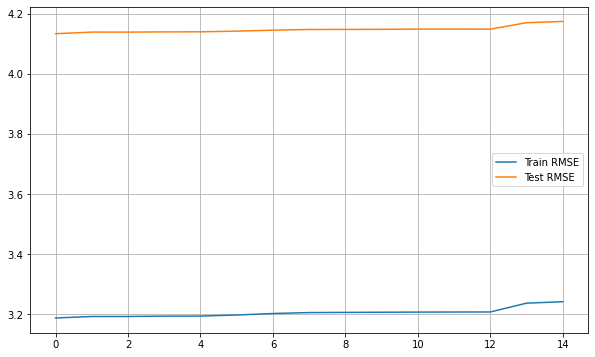

In [20]:
from sklearn.preprocessing import PolynomialFeatures
Trr=[]; Tss=[]; n=3
order=['ord-'+str(i) for i in range(2,n)]
#Trd = pd.DataFrame(np.zeros((10,n-2)), columns=order)
#Tsd = pd.DataFrame(np.zeros((10,n-2)), columns=order)

DROP=[];b=[]

for i in tqdm(range(len(Train_X_std.columns)-1)):
    vif = pd.DataFrame()
    X = Train_X_std.drop(DROP,axis=1)
    vif['Features'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    vif.reset_index(drop=True, inplace=True)
    if vif.loc[0][1]>=1.1:
        DROP.append(vif.loc[0][0])
        LR = LinearRegression()
        LR.fit(Train_X_std.drop(DROP,axis=1), Train_Y)

        pred1 = LR.predict(Train_X_std.drop(DROP,axis=1))
        pred2 = LR.predict(Test_X_std.drop(DROP,axis=1))
        
        Trr.append(np.sqrt(mean_squared_error(Train_Y, pred1)))
        Tss.append(np.sqrt(mean_squared_error(Test_Y, pred2)))

        #Trd.loc[i,'ord-'+str(k)] = round(np.sqrt(mean_squared_error(Train_Y, pred1)),2)
        #Tsd.loc[i,'ord-'+str(k)] = round(np.sqrt(mean_squared_error(Test_Y, pred2)),2)
        
print('Dropped Features --> ',DROP)


plt.plot(Trr, label='Train RMSE')
plt.plot(Tss, label='Test RMSE')
#plt.ylim([19.75,20.75])
plt.legend()
plt.grid()
plt.show()

100%|██████████| 31/31 [00:28<00:00,  1.07it/s]


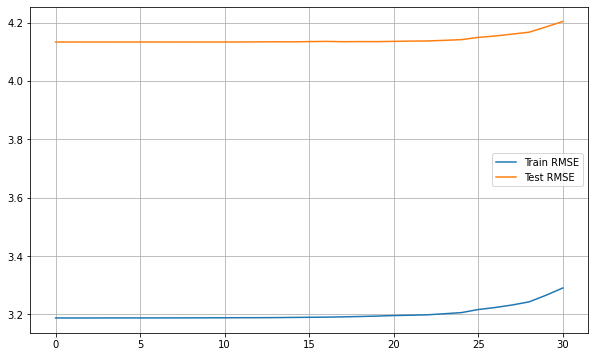

In [21]:
from sklearn.preprocessing import PolynomialFeatures
Trr=[]; Tss=[]; n=3
order=['ord-'+str(i) for i in range(2,n)]
Trd = pd.DataFrame(np.zeros((10,n-2)), columns=order)
Tsd = pd.DataFrame(np.zeros((10,n-2)), columns=order)

m=df.shape[1]-2
for i in tqdm(range(m)):
    lm = LinearRegression()
    #lm.fit(Train_X_std, Train_Y)

    rfe = RFE(lm,n_features_to_select=Train_X_std.shape[1]-i)             # running RFE
    rfe = rfe.fit(Train_X_std, Train_Y)
    
    #print(Train_X_std.shape[1]-i)

    #Train_xy = pd.concat([Train_X_std[Train_X.columns[rfe.support_]],Train_Y.reset_index(drop=True)],axis=1)
    #a = Train_xy.columns.values.tolist()
    #a.remove(target)

    #API = api.ols(formula='{} ~ {}'.format(target,' + '.join(i for i in a)), data=Train_xy).fit()
    #DROP.append(vif.loc[0][0])
    LR = LinearRegression()
    LR.fit(Train_X_std.loc[:,rfe.support_], Train_Y)
    
    #print(Train_X_std.loc[:,rfe.support_].columns)

    pred1 = LR.predict(Train_X_std.loc[:,rfe.support_])
    pred2 = LR.predict(Test_X_std.loc[:,rfe.support_])

    Trr.append(np.sqrt(mean_squared_error(Train_Y, pred1)))
    Tss.append(np.sqrt(mean_squared_error(Test_Y, pred2)))


plt.plot(Trr, label='Train RMSE')
plt.plot(Tss, label='Test RMSE')
#plt.ylim([19.75,20.75])
plt.legend()
plt.grid()
plt.show()

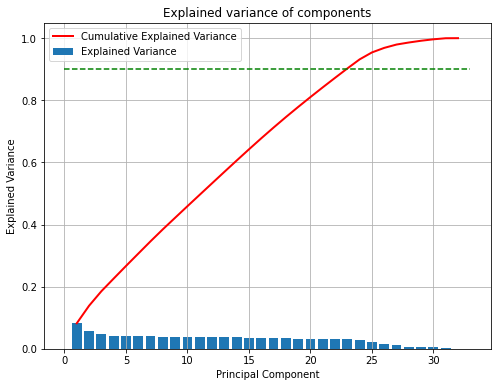

In [22]:
from sklearn.decomposition import PCA

pca = PCA().fit(Train_X_std)

fig, ax = plt.subplots(figsize=(8,6))
x_values = range(1, pca.n_components_+1)
ax.bar(x_values, pca.explained_variance_ratio_, lw=2, label='Explained Variance')
ax.plot(x_values, np.cumsum(pca.explained_variance_ratio_), lw=2, label='Cumulative Explained Variance', color='red')
plt.plot([0,pca.n_components_+1],[0.9,0.9],'g--')
ax.set_title('Explained variance of components')
ax.set_xlabel('Principal Component')
ax.set_ylabel('Explained Variance')
plt.legend()
plt.grid()
plt.show()

100%|██████████| 29/29 [00:16<00:00,  1.75it/s]


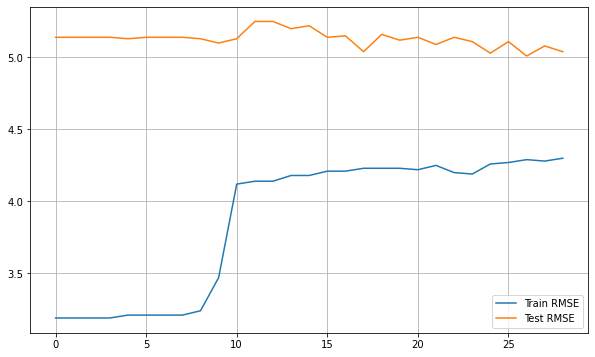

In [23]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures
Trr=[]; Tss=[]; n=3
order=['ord-'+str(i) for i in range(2,n)]
Trd = pd.DataFrame(np.zeros((10,n-2)), columns=order)
Tsd = pd.DataFrame(np.zeros((10,n-2)), columns=order)
m=df.shape[1]-4

for i in tqdm(range(m)):
    pca = PCA(n_components=Train_X_std.shape[1]-i)
    Train_X_std_pca = pca.fit_transform(Train_X_std)
    Test_X_std_pca = pca.fit_transform(Test_X_std)
    
    LR = LinearRegression()
    LR.fit(Train_X_std_pca, Train_Y)

    pred1 = LR.predict(Train_X_std_pca)
    pred2 = LR.predict(Test_X_std_pca)

    Trr.append(round(np.sqrt(mean_squared_error(Train_Y, pred1)),2))
    Tss.append(round(np.sqrt(mean_squared_error(Test_Y, pred2)),2))

plt.plot(Trr, label='Train RMSE')
plt.plot(Tss, label='Test RMSE')
#plt.ylim([19.5,20.75])
plt.legend()
plt.grid()
plt.show()

In [24]:
#Shortlisting the selected Features (with RFE)

lm = LinearRegression()
rfe = RFE(lm,n_features_to_select=df.shape[1]-23)           
rfe = rfe.fit(Train_X_std, Train_Y)

LR = LinearRegression()
LR.fit(Train_X_std.loc[:,rfe.support_], Train_Y)

#print(Train_X_std.loc[:,rfe.support_].columns)

pred1 = LR.predict(Train_X_std.loc[:,rfe.support_])
pred2 = LR.predict(Test_X_std.loc[:,rfe.support_])

print(np.sqrt(mean_squared_error(Train_Y, pred1)))
print(np.sqrt(mean_squared_error(Test_Y, pred2)))

Train_X_std = Train_X_std.loc[:,rfe.support_]
Test_X_std = Test_X_std.loc[:,rfe.support_]

3.1983347651367957
4.137026089981123


# # 6. Predictive Modelling

In [27]:
#Let us first define a function to evaluate our models

Model_Evaluation_Comparison_Matrix = pd.DataFrame(np.zeros([5,8]), columns=['Train-R2','Test-R2','Train-RSS','Test-RSS',
                                                                            'Train-MSE','Test-MSE','Train-RMSE','Test-RMSE'])
rc=np.random.choice(Train_X_std.loc[:,Train_X_std.nunique()>50].columns,3)
def Evaluate(n, pred1,pred2):
    #Plotting predicted predicteds alongside the actual datapoints 
    plt.figure(figsize=[15,6])
    for e,i in enumerate(rc):
        plt.subplot(2,3,e+1)
        plt.scatter(y=Train_Y, x=Train_X_std[i], label='Actual')
        plt.scatter(y=pred1, x=Train_X_std[i], label='Prediction')
        plt.legend()
    plt.show()

    #Evaluating the Multiple Linear Regression Model

    print('\n\n{}Training Set Metrics{}'.format('-'*20, '-'*20))
    print('\nR2-Score on Training set --->',round(r2_score(Train_Y, pred1),20))
    print('Residual Sum of Squares (RSS) on Training set  --->',round(np.sum(np.square(Train_Y-pred1)),20))
    print('Mean Squared Error (MSE) on Training set       --->',round(mean_squared_error(Train_Y, pred1),20))
    print('Root Mean Squared Error (RMSE) on Training set --->',round(np.sqrt(mean_squared_error(Train_Y, pred1)),20))

    print('\n{}Testing Set Metrics{}'.format('-'*20, '-'*20))
    print('\nR2-Score on Testing set --->',round(r2_score(Test_Y, pred2),20))
    print('Residual Sum of Squares (RSS) on Training set  --->',round(np.sum(np.square(Test_Y-pred2)),20))
    print('Mean Squared Error (MSE) on Training set       --->',round(mean_squared_error(Test_Y, pred2),20))
    print('Root Mean Squared Error (RMSE) on Training set --->',round(np.sqrt(mean_squared_error(Test_Y, pred2)),20))
    print('\n{}Residual Plots{}'.format('-'*20, '-'*20))
    
    Model_Evaluation_Comparison_Matrix.loc[n,'Train-R2']  = round(r2_score(Train_Y, pred1),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Test-R2']   = round(r2_score(Test_Y, pred2),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Train-RSS'] = round(np.sum(np.square(Train_Y-pred1)),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Test-RSS']  = round(np.sum(np.square(Test_Y-pred2)),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Train-MSE'] = round(mean_squared_error(Train_Y, pred1),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Test-MSE']  = round(mean_squared_error(Test_Y, pred2),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Train-RMSE']= round(np.sqrt(mean_squared_error(Train_Y, pred1)),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Test-RMSE'] = round(np.sqrt(mean_squared_error(Test_Y, pred2)),20)

    # Plotting y_test and y_pred to understand the spread.
    plt.figure(figsize=[15,4])

    plt.subplot(1,2,1)
    sns.distplot((Train_Y - pred1))
    plt.title('Error Terms')          
    plt.xlabel('Errors') 

    plt.subplot(1,2,2)
    plt.scatter(Train_Y,pred1)
    plt.plot([Train_Y.min(),Train_Y.max()],[Train_Y.min(),Train_Y.max()], 'r--')
    plt.title('Test vs Prediction')         
    plt.xlabel('y_test')                       
    plt.ylabel('y_pred')                       
    plt.show()

Objective: Let us now try building multiple regression models & compare their evaluation metrics to choose the best fit model both training and testing sets...

6a. Multiple Linear Regression(MLR)¶


<<<------------------------- Evaluating Multiple Linear Regression Model ------------------------->>>

The Coeffecient of the Regresion Model was found to be  [-0.30499538  2.79702093  0.15508619  0.32086946  0.39552625  0.29085972
  0.16782406  0.50924681  0.59332707  0.44376597]
The Intercept of the Regresion Model was found to be  8.550616948269791


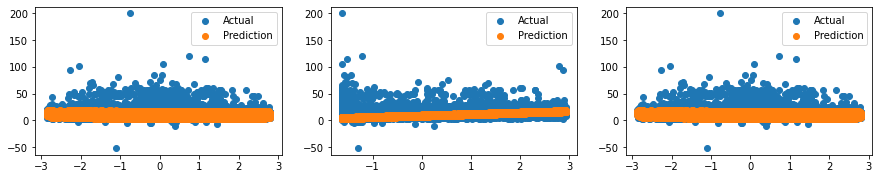



--------------------Training Set Metrics--------------------

R2-Score on Training set ---> 0.4535189574339897
Residual Sum of Squares (RSS) on Training set  ---> 1335563.7771264175
Mean Squared Error (MSE) on Training set       ---> 10.229345269882643
Root Mean Squared Error (RMSE) on Training set ---> 3.1983347651367953

--------------------Testing Set Metrics--------------------

R2-Score on Testing set ---> 0.3282075840111336
Residual Sum of Squares (RSS) on Training set  ---> 558650.2211150512
Mean Squared Error (MSE) on Training set       ---> 17.114984869184497
Root Mean Squared Error (RMSE) on Training set ---> 4.137026089981123

--------------------Residual Plots--------------------


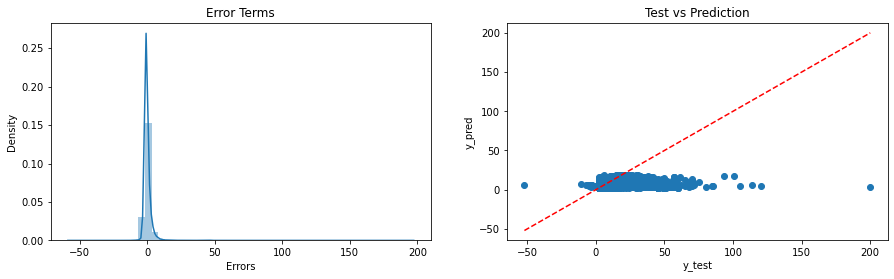

In [28]:
#Linear Regression

MLR = LinearRegression().fit(Train_X_std,Train_Y)
pred1 = MLR.predict(Train_X_std)
pred2 = MLR.predict(Test_X_std)

print('{}{}\033[1m Evaluating Multiple Linear Regression Model \033[0m{}{}\n'.format('<'*3,'-'*25 ,'-'*25,'>'*3))
print('The Coeffecient of the Regresion Model was found to be ',MLR.coef_)
print('The Intercept of the Regresion Model was found to be ',MLR.intercept_)

Evaluate(0, pred1, pred2)

6b. Ridge Regression Model¶


<<<------------------------- Evaluating Ridge Regression Model ------------------------->>>

The Coeffecient of the Regresion Model was found to be  [-0.30499538  2.79702093  0.15508619  0.32086946  0.39552625  0.29085972
  0.16782406  0.50924681  0.59332707  0.44376597]
The Intercept of the Regresion Model was found to be  8.550616948269791


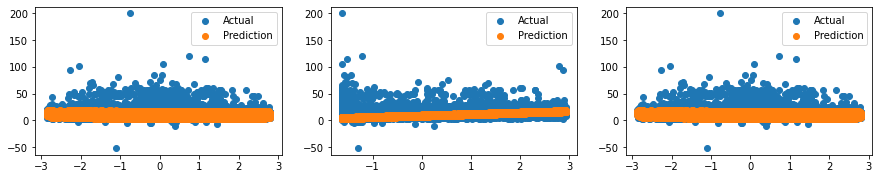



--------------------Training Set Metrics--------------------

R2-Score on Training set ---> 0.45351895740097714
Residual Sum of Squares (RSS) on Training set  ---> 1335563.7772070982
Mean Squared Error (MSE) on Training set       ---> 10.229345270500591
Root Mean Squared Error (RMSE) on Training set ---> 3.1983347652334007

--------------------Testing Set Metrics--------------------

R2-Score on Testing set ---> 0.328207646931304
Residual Sum of Squares (RSS) on Training set  ---> 558650.1687917943
Mean Squared Error (MSE) on Training set       ---> 17.114983266192652
Root Mean Squared Error (RMSE) on Training set ---> 4.137025896243901

--------------------Residual Plots--------------------


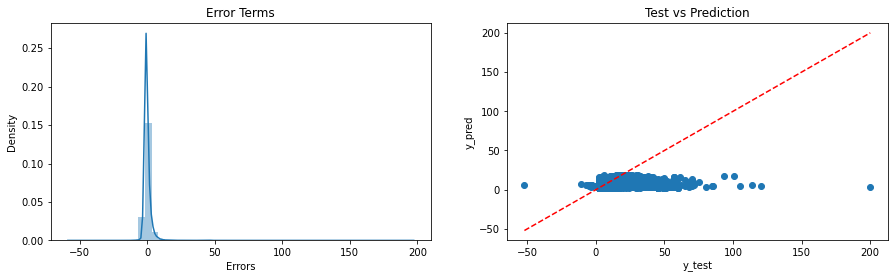

In [29]:
#Creating a Ridge Regression model

RLR = Ridge().fit(Train_X_std,Train_Y)
pred1 = RLR.predict(Train_X_std)
pred2 = RLR.predict(Test_X_std)

print('{}{}\033[1m Evaluating Ridge Regression Model \033[0m{}{}\n'.format('<'*3,'-'*25 ,'-'*25,'>'*3))
print('The Coeffecient of the Regresion Model was found to be ',MLR.coef_)
print('The Intercept of the Regresion Model was found to be ',MLR.intercept_)

Evaluate(1, pred1, pred2)

6c. Lasso Regression Model

<<<------------------------- Evaluating Lasso Regression Model ------------------------->>>

The Coeffecient of the Regresion Model was found to be  [-0.30499538  2.79702093  0.15508619  0.32086946  0.39552625  0.29085972
  0.16782406  0.50924681  0.59332707  0.44376597]
The Intercept of the Regresion Model was found to be  8.550616948269791


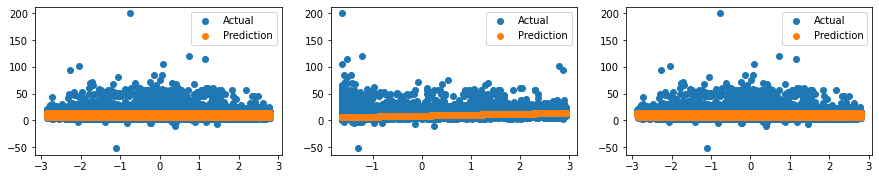



--------------------Training Set Metrics--------------------

R2-Score on Training set ---> 0.3585502318636643
Residual Sum of Squares (RSS) on Training set  ---> 1567661.1052167423
Mean Squared Error (MSE) on Training set       ---> 12.007024288971845
Root Mean Squared Error (RMSE) on Training set ---> 3.4651153355944513

--------------------Testing Set Metrics--------------------

R2-Score on Testing set ---> 0.2622605216343987
Residual Sum of Squares (RSS) on Training set  ---> 613490.5856410799
Mean Squared Error (MSE) on Training set       ---> 18.795091622226032
Root Mean Squared Error (RMSE) on Training set ---> 4.335330624326827

--------------------Residual Plots--------------------


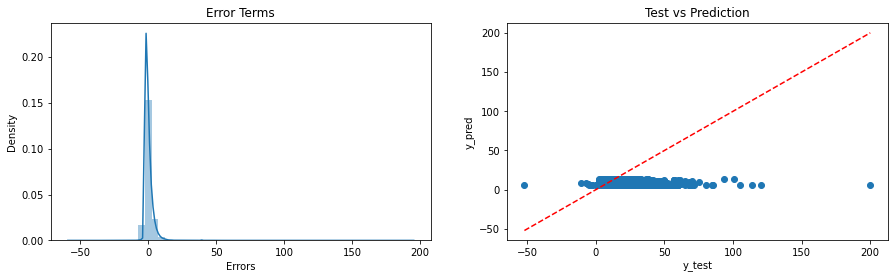

In [30]:
#Creating a Ridge Regression model

LLR = Lasso().fit(Train_X_std,Train_Y)
pred1 = LLR.predict(Train_X_std)
pred2 = LLR.predict(Test_X_std)

print('{}{}\033[1m Evaluating Lasso Regression Model \033[0m{}{}\n'.format('<'*3,'-'*25 ,'-'*25,'>'*3))
print('The Coeffecient of the Regresion Model was found to be ',MLR.coef_)
print('The Intercept of the Regresion Model was found to be ',MLR.intercept_)

Evaluate(2, pred1, pred2)

6d. Elastic-Net Regression

<<<------------------------- Evaluating Elastic-Net Regression Model ------------------------->>>

The Coeffecient of the Regresion Model was found to be  [-0.30499538  2.79702093  0.15508619  0.32086946  0.39552625  0.29085972
  0.16782406  0.50924681  0.59332707  0.44376597]
The Intercept of the Regresion Model was found to be  8.550616948269791


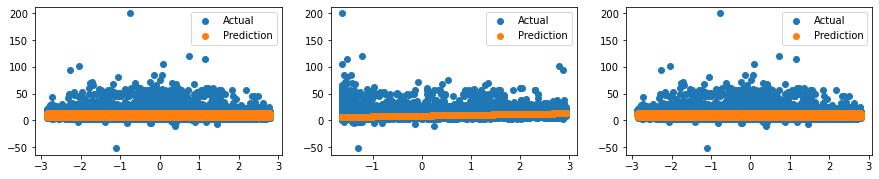



--------------------Training Set Metrics--------------------

R2-Score on Training set ---> 0.32729497804639207
Residual Sum of Squares (RSS) on Training set  ---> 1644046.8928137545
Mean Squared Error (MSE) on Training set       ---> 12.5920780381256
Root Mean Squared Error (RMSE) on Training set ---> 3.5485318144446163

--------------------Testing Set Metrics--------------------

R2-Score on Testing set ---> 0.23952090035803755
Residual Sum of Squares (RSS) on Training set  ---> 632400.4365887308
Mean Squared Error (MSE) on Training set       ---> 19.37441979684234
Root Mean Squared Error (RMSE) on Training set ---> 4.401638308271403

--------------------Residual Plots--------------------


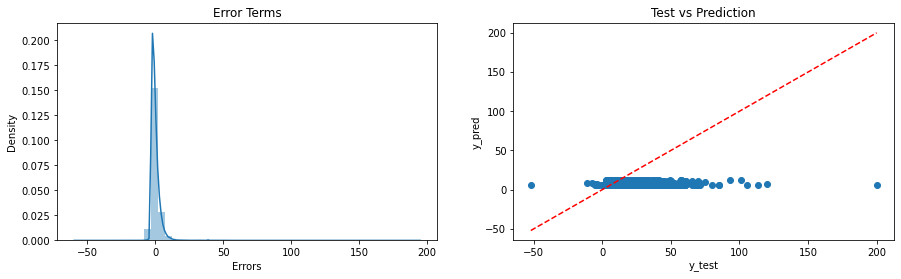

In [31]:
#Creating a ElasticNet Regression model

ENR = ElasticNet().fit(Train_X_std,Train_Y)
pred1 = ENR.predict(Train_X_std)
pred2 = ENR.predict(Test_X_std)

print('{}{}\033[1m Evaluating Elastic-Net Regression Model \033[0m{}{}\n'.format('<'*3,'-'*25 ,'-'*25,'>'*3))
print('The Coeffecient of the Regresion Model was found to be ',MLR.coef_)
print('The Intercept of the Regresion Model was found to be ',MLR.intercept_)

Evaluate(3, pred1, pred2)

6e. Polynomial Regression Model

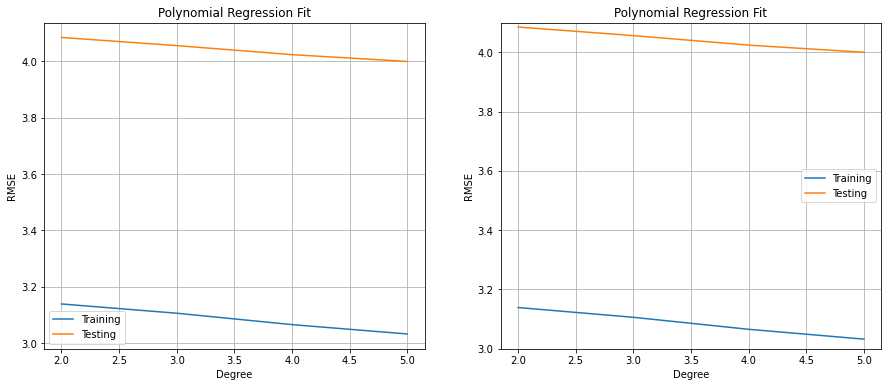

In [32]:
#Checking polynomial regression performance on various degrees

Trr=[]; Tss=[]
n_degree=6

for i in range(2,n_degree):
    #print(f'{i} Degree')
    poly_reg = PolynomialFeatures(degree=i)
    X_poly = poly_reg.fit_transform(Train_X_std)
    X_poly1 = poly_reg.fit_transform(Test_X_std)
    LR = LinearRegression()
    LR.fit(X_poly, Train_Y)
    
    pred1 = LR.predict(X_poly)
    Trr.append(np.sqrt(mean_squared_error(Train_Y, pred1)))
    
    pred2 = LR.predict(X_poly1)
    Tss.append(np.sqrt(mean_squared_error(Test_Y, pred2)))

plt.figure(figsize=[15,6])
plt.subplot(1,2,1)
plt.plot(range(2,n_degree),Trr, label='Training')
plt.plot(range(2,n_degree),Tss, label='Testing')
#plt.plot([1,4],[1,4],'b--')
plt.title('Polynomial Regression Fit')
#plt.ylim([0,5])
plt.xlabel('Degree')
plt.ylabel('RMSE')
plt.grid()
plt.legend()
#plt.xticks()

plt.subplot(1,2,2)
plt.plot(range(2,n_degree),Trr, label='Training')
plt.plot(range(2,n_degree),Tss, label='Testing')
plt.title('Polynomial Regression Fit')
plt.ylim([3,4.1])
plt.xlabel('Degree')
plt.ylabel('RMSE')
plt.grid()
plt.legend()
#plt.xticks()
plt.show()

<<<------------------------- Evaluating Polynomial Regression Model ------------------------->>>

The Coeffecient of the Regresion Model was found to be  [-0.30499538  2.79702093  0.15508619  0.32086946  0.39552625  0.29085972
  0.16782406  0.50924681  0.59332707  0.44376597]
The Intercept of the Regresion Model was found to be  8.550616948269791


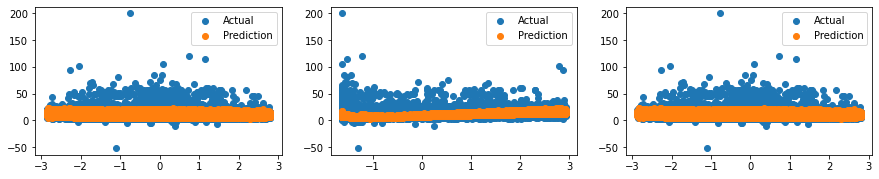



--------------------Training Set Metrics--------------------

R2-Score on Training set ---> 0.5086898476352086
Residual Sum of Squares (RSS) on Training set  ---> 1200729.744899826
Mean Squared Error (MSE) on Training set       ---> 9.196624936044376
Root Mean Squared Error (RMSE) on Training set ---> 3.032593763767969

--------------------Testing Set Metrics--------------------

R2-Score on Testing set ---> 0.3719574132341533
Residual Sum of Squares (RSS) on Training set  ---> 522268.6675465888
Mean Squared Error (MSE) on Training set       ---> 16.000388086963905
Root Mean Squared Error (RMSE) on Training set ---> 4.000048510576328

--------------------Residual Plots--------------------


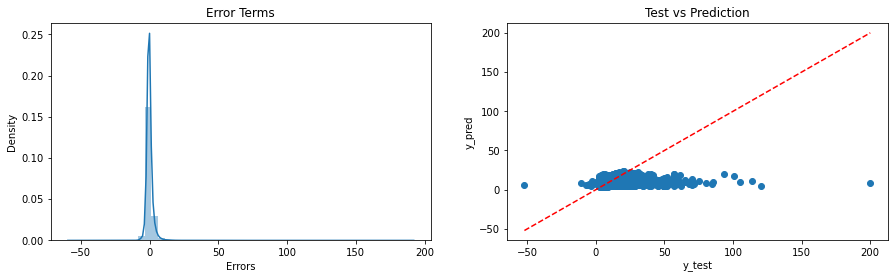

In [33]:
#Using the 5th Order Polynomial Regression model (degree=5)

poly_reg = PolynomialFeatures(degree=5)
X_poly = poly_reg.fit_transform(Train_X_std)
X_poly1 = poly_reg.fit_transform(Test_X_std)
PR = LinearRegression()
PR.fit(X_poly, Train_Y)

pred1 = PR.predict(X_poly)
pred2 = PR.predict(X_poly1)

print('{}{}\033[1m Evaluating Polynomial Regression Model \033[0m{}{}\n'.format('<'*3,'-'*25 ,'-'*25,'>'*3))
print('The Coeffecient of the Regresion Model was found to be ',MLR.coef_)
print('The Intercept of the Regresion Model was found to be ',MLR.intercept_)

Evaluate(4, pred1, pred2)

6f. Comparing the Evaluation Metics of the Models


In [34]:
# Regression Models Results Evaluation

EMC = Model_Evaluation_Comparison_Matrix.copy()
EMC.index = ['Multiple Linear Regression (MLR)','Ridge Linear Regression (RLR)','Lasso Linear Regression (LLR)','Elastic-Net Regression (ENR)','Polynomial Regression (PNR)']
EMC

,Train-R2,Test-R2,Train-RSS,Test-RSS,Train-MSE,Test-MSE,Train-RMSE,Test-RMSE
Multiple Linear Regression (MLR),0.453519,0.328208,1.335564e+06,558650.221115,10.229345,17.114985,3.198335,4.137026
Ridge Linear Regression (RLR),0.453519,0.328208,1.335564e+06,558650.168792,10.229345,17.114983,3.198335,4.137026
Lasso Linear Regression (LLR),0.358550,0.262261,1.567661e+06,613490.585641,12.007024,18.795092,3.465115,4.335331
Elastic-Net Regression (ENR),0.327295,0.239521,1.644047e+06,632400.436589,12.592078,19.374420,3.548532,4.401638
Polynomial Regression (PNR),0.508690,0.371957,1.200730e+06,522268.667547,9.196625,16.000388,3.032594,4.000049


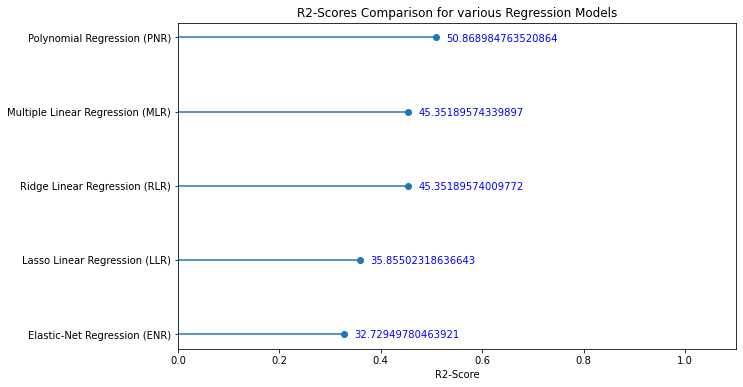

In [35]:
# R2-Scores Comparison for different Regression Models

R2 = EMC['Train-R2'].sort_values(ascending=True)
plt.hlines(y=R2.index, xmin=0, xmax=R2.values)
plt.plot(R2.values, R2.index,'o')
plt.title('R2-Scores Comparison for various Regression Models')
plt.xlabel('R2-Score')
#plt.ylabel('Regression Models')
for i, v in enumerate(R2):
    plt.text(v+0.02, i-0.05, str(v*100), color='blue')
plt.xlim([0,1.1])
plt.show()

Inference: From the above plot, it is clear that the polynomial regresion models have the highest explainability power to understand the dataset.

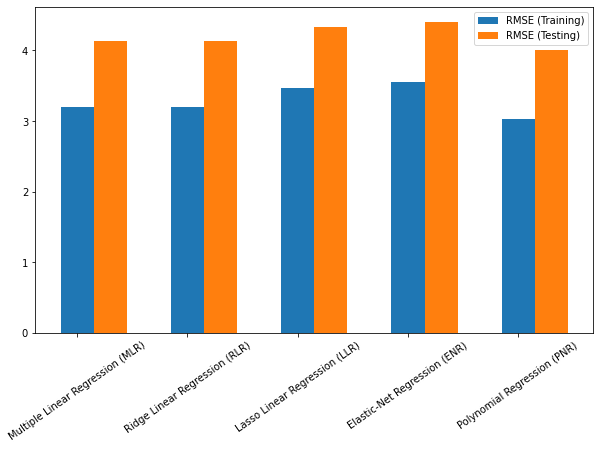

In [36]:
# Root Mean SquaredError Comparison for different Regression Models

cc = Model_Evaluation_Comparison_Matrix.columns.values
plt.bar(np.arange(5), Model_Evaluation_Comparison_Matrix[cc[6]].values, width=0.3, label='RMSE (Training)')
plt.bar(np.arange(5)+0.3, Model_Evaluation_Comparison_Matrix[cc[7]].values, width=0.3, label='RMSE (Testing)')
plt.xticks(np.arange(5),EMC.index, rotation=35)
plt.legend()
plt.show()

Inference: The complex models like polynomial (degree-5) performs the best on the current dataset. For this problem, it is can be said that even simple regression can be a good choice to go with..